In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson, skellam
from sklearn import preprocessing

import statsmodels.api as sm
import statsmodels.formula.api as smf

/Users/oliver.hofmann/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [32]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={"name": homeTeam, 
                                                            "opponentName": awayTeam,"neutralVenue":1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={"name": awayTeam, 
                                                            "opponentName": homeTeam,"neutralVenue":0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1]))), home_goals_avg, away_goals_avg

In [2]:
data = pd.read_csv("matches.csv", header=0, encoding="latin-1")

prepared_data = pd.DataFrame()

homeVenue = list()
for i, d in data["team1Text"].iteritems():
    v = data["venue"].get(i)
    h = False
    if isinstance(v, str) and d in v:
        h = True
    homeVenue.append(h)
    
prepared_data["date"] = data.date
prepared_data["name"] = data["team1"]
prepared_data["opponentName"] = data["team2"]
prepared_data["homeVenue"] = homeVenue
prepared_data["neutralVenue"] = [not v for v in homeVenue]
prepared_data["homeScore"] = data.team1Score
prepared_data["opponentScore"] = data.team2Score
prepared_data["differenceScore"] = data.team1Score - data.team2Score
prepared_data["homeWin"] = data.team1Score > data.team2Score
prepared_data["opponentWin"] = data.team1Score < data.team2Score
prepared_data["draw"] = data.team1Score == data.team2Score

prepared_data.head()

,date,name,opponentName,homeVenue,neutralVenue,homeScore,opponentScore,differenceScore,homeWin,opponentWin,draw
0,19560930,AUT,LUX,True,False,7,0,7,True,False,False
1,19561003,IRL,DEN,True,False,2,1,1,True,False,False
2,19561111,FRA,BEL,True,False,6,3,3,True,False,False
3,19561205,ENG,DEN,True,False,5,2,3,True,False,False
4,19570310,ESP,SUI,True,False,2,2,0,False,False,True


In [10]:
data_team_score = prepared_data[["name", "opponentName", "homeScore", "opponentScore"]]
data_team_score_venue = prepared_data[["name", "opponentName", "homeScore", "opponentScore", "neutralVenue"]]
data_team_score.mean()

homeScore        1.709336
opponentScore    1.093823
dtype: float64

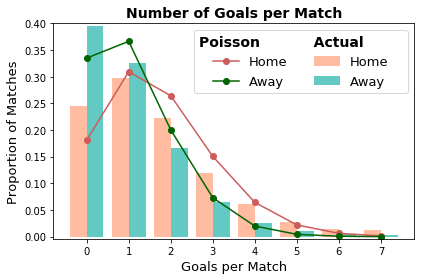

In [5]:
poisson_pred = np.column_stack([[poisson.pmf(i, data_team_score.mean()[j]) for i in range(8)] for j in range(2)])

# plot histogram of actual goals
plt.hist(data_team_score[['homeScore', 'opponentScore']].values, range(9), 
         alpha=0.7, label=['Home', 'Away'],normed=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

In [6]:
# probability of draw between home and away team
skellam.pmf(0.0,  data_team_score.mean()[0],  data_team_score.mean()[1])

0.23932793588332998

In [7]:
# probability of home team winning by one goal
skellam.pmf(1,  data_team_score.mean()[0],  data_team_score.mean()[1])

0.23584094555711743

In [12]:
poisson_model = smf.glm(formula="homeScore ~ neutralVenue + name + opponentName", data=data_team_score_venue, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              homeScore   No. Observations:                34256
Model:                            GLM   Df Residuals:                    33810
Model Family:                 Poisson   Df Model:                          445
Link Function:                    log   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -54162.
Date:                Wed, 25 Apr 2018   Deviance:                       41724.
Time:                        20:36:36   Pearson chi2:                 3.81e+04
No. Iterations:                     6                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.2998      0.180      1.668      0.095      -0.053       0.652
neutralVenue[T.True]    -0.0593      0.010     -6.214      0.000      -0.078      -0.041
name[T.AIA]             -1.1831      0.442     -2.678      0.007      -2.049      -0.317
name[T.ALB]              0.9706      0.180      5.390      0.000       0.618       1.324
name[T.ALG]              1.2930      0.168      7.676      0.000       0.963       1.623
name[T.AND]             -0.3286      0.276     -1.191      0.234      -0.869       0.212
name[T.ANG]              0.9381      0.176      5.329      0.000       0.593       1.283
name[T.ANT]              0.5718      0.191      2.994      0.003       0.197       0.946
name[T.ARG]              1.8767      0.165     11.350      0.000       1.553       2.201
name[T.ARM]              0.9304      0.192      4.833      0.000       0.553       1.308
name[T.ARU]              0.2819      0.215      1.313      0.189      -0.139       0.703
name[T.ASA]             -1.6258      0.377     -4.318      0.000      -2.364      -0.888
name[T.ATG]              0.3096      0.186      1.660      0.097      -0.056       0.675
name[T.AUS]              1.2915      0.167      7.727      0.000       0.964       1.619
name[T.AUT]              1.6241      0.167      9.719      0.000       1.297       1.952
name[T.AZE]              0.5668      0.194      2.924      0.003       0.187       0.947
name[T.BAH]             -0.3122      0.260     -1.200      0.230      -0.822       0.198
name[T.BAN]              0.0283      0.185      0.153      0.878      -0.334       0.390
name[T.BDI]              0.5367      0.195      2.750      0.006       0.154       0.919
name[T.BEL]              1.6972      0.167     10.185      0.000       1.371       2.024
name[T.BEN]              0.8889      0.184      4.843      0.000       0.529       1.249
name[T.BER]              0.6274      0.186      3.378      0.001       0.263       0.991
name[T.BFA]              0.9900      0.179      5.525      0.000       0.639       1.341
name[T.BHR]              0.9303      0.168      5.522      0.000       0.600       1.260
name[T.BHU]             -0.6666      0.312     -2.135      0.033      -1.279      -0.055
name[T.BIH]              1.3324      0.181      7.355      0.000       0.977       1.687
name[T.BLR]              1.2145      0.182      6.676      0.000       0.858       1.571
name[T.BLZ]              0.2426      0.246      0.986      0.324      -0.240       0.725
name[T.BOL]              1.4525      0.173      8.400      0.000       1.114       1.791
name[T.BOT]              0.3574      0.186      1.919      0.055      -0.008       0.723
name[T.BRA]              1.9746      0.164     12.047      0.000       1.653       2.296
name[T.BRB]              0.3896      0.184      2.123      0.034       0.030       0.749
name[T.BRU]             -0.3336      0.241     

In [28]:
poisson_model.predict(pd.DataFrame(data={"name": "SUI", "opponentName": "ALB",
                                       "neutralVenue":1},index=[1]))

1    2.194909
dtype: float64

In [29]:
poisson_model.predict(pd.DataFrame(data={"name": "ALB", "opponentName": "SUI",
                                       "neutralVenue":1},index=[1]))

1    0.846183
dtype: float64

In [47]:
draw_win, homeGoals, awayGoals = simulate_match(poisson_model, "EGY", "URY", max_goals=10)
print("Goals SUI:", homeGoals)
print("Goals ALB:", awayGoals)
print("SUI win:", np.sum(np.tril(draw_win, -1)))
print("Draw:", np.sum(np.diag(draw_win)))
print("ALB win:", np.sum(np.triu(draw_win, 1)))

PatsyError: Error converting data to categorical: observation with value 'URY' does not match any of the expected levels (expected: ['AFG', 'AIA', ..., 'ZAM', 'ZIM'])
    homeScore ~ neutralVenue + name + opponentName
                                      ^^^^^^^^^^^^